In [1]:
%matplotlib inline
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from caen_felib import lib, device, error

# Get CAEN FELib path
print(f'CAEN FELib found at: {lib.path} (version={lib.version})')

CAEN FELib found at: libCAEN_FELib.so (version=1.3.1)


In [2]:
from lgdo import lh5, Table, Array, WaveformTable, ArrayOfEqualSizedArrays

## Connect

In [3]:
dig = device.connect('dig2://192.168.0.254')#caendgtz-usb-21233')
print(f'Connected to digitizer (handle={hex(dig.handle)}, name={dig.name})')

Connected to digitizer (handle=0xcae0000000000000, name=)


In [4]:
# Reset
dig.cmd.Reset()

fw_type = dig.par.fwtype.value
fw_ver = dig.par.fpga_fwver.value
print(fw_type, fw_ver)

adc_samplrate_msps = float(dig.par.adc_samplrate.value)  # in Msps
adc_n_bits = int(dig.par.adc_nbit.value)
sampling_period_ns = int(1e3 / adc_samplrate_msps)

print(f"Sampling rate = {adc_samplrate_msps} MHz, n. bit = {adc_n_bits}, Sampling period = {sampling_period_ns} ns")

# Configuration parameters
nch = int(dig.par.NumCh.value)
active_ch = 1
reclen = 4084 #sample
pretrg = 2042 #sample
dc_offset = 50

dig.par.iolevel.value = "TTL"
dig.par.acqtriggersource.value = "TrgIn"
dig.par.recordlengths.value = f"{reclen}"
dig.par.pretriggers.value = f"{pretrg}"

# Set some channel parameters
for i, ch in enumerate(dig.ch):
    ch.par.chenable.value = "TRUE" if i < active_ch else "FALSE"  # Enable only channel 0
    ch.par.dcoffset.value = f"{dc_offset}"

Scope 0.5.238
Sampling rate = 125.0 MHz, n. bit = 16, Sampling period = 8 ns


## Configure endpoint

In [5]:
data_format = [
    {
        'name': 'EVENT_SIZE',
        'type': 'SIZE_T',
    },
    {
        'name': 'TIMESTAMP',
        'type': 'U64',
    },
    {
        'name': 'WAVEFORM',
        'type': 'U16',
        'dim': 2,
        'shape': [active_ch, reclen],
    },
    {
        'name': 'WAVEFORM_SIZE',
        'type': 'U64',
        'dim': 1,
        'shape': [active_ch],
    },
]

In [6]:
decoded_endpoint_path = 'scope'
endpoint = dig.endpoint[decoded_endpoint_path]
data = endpoint.set_read_data_format(data_format)
dig.endpoint.par.ACTIVEENDPOINT.value = decoded_endpoint_path

event_size = data[0].value
timestamp = data[1].value
waveform = data[2].value
waveform_size = data[3].value

In [7]:
nev = 10
timestamps = np.zeros((active_ch,nev),dtype=np.uint64)
wfs = np.zeros((active_ch,nev,reclen),dtype=np.uint16)
temp_names = ["tempsensfirstadc","tempsenshottestadc","tempsenslastadc","tempsensairin","tempsensairout","tempsenscore","tempsensdcdc"]
temperatures = np.zeros((nev,len(temp_names)),dtype=float)

In [23]:
dig.cmd.armacquisition()
dig.cmd.swstartacquisition()
for i in range(nev):
    try:
        endpoint.read_data(-1, data)
    except error.Error as ex:
        if ex.code == error.ErrorCode.TIMEOUT:
            continue
        if ex.code == error.ErrorCode.STOP:
            break
        else:
            raise ex
    for j in range(active_ch):
        wfs[j,i] = waveform[j]
        timestamps[j,i] = timestamp
        for k, temp in enumerate(temp_names):
            temp_value = float(dig.get_value(f"/par/{temp}"))
            temperatures[i][k] = temp_value
dig.cmd.disarmacquisition()

In [24]:
raw_file = "/mnt/c/Users/valda/data/test_LNGS_V2740/20241007/prova_000.lh5"
raw_data = lh5.read("ch000/raw",raw_file)
wfs = raw_data.waveform.values.nda
timestamp = raw_data.timestamp.nda
#temp0 = raw_data.temp0.nda
print(raw_data.keys())

dict_keys(['waveform', 'timestamp'])


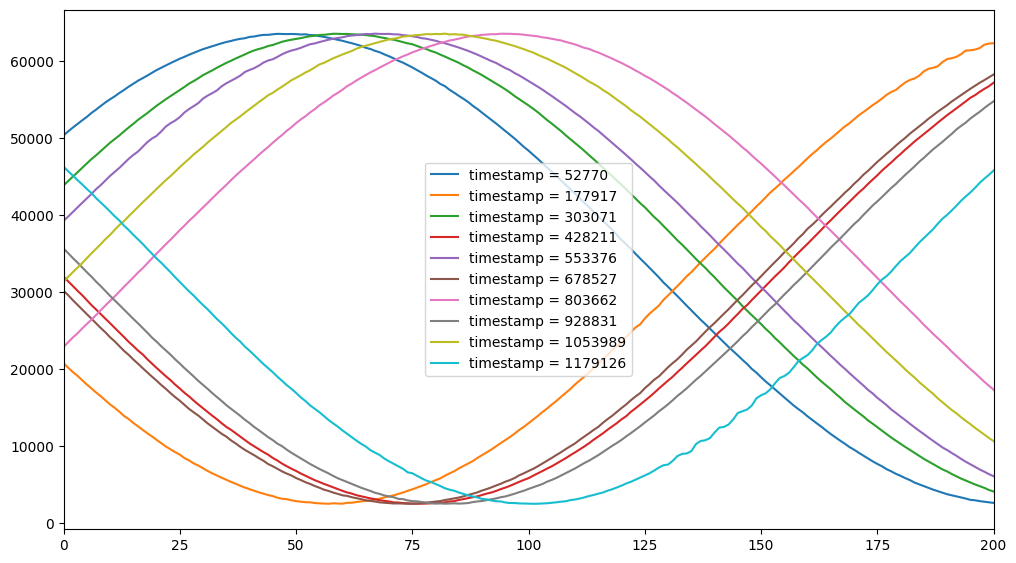

In [25]:
fig, ax = plt.subplots(figsize=(12,6.75))
for i in range(10):
    ax.plot(wfs[i],label=f"timestamp = {timestamp[i]}")
ax.set_xlim(0,200)
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6.75))
#ax.plot(voltages,wf_max,"b.")
pars = np.polyfit(voltages,wf_max,1)
ax.plot(wf_max,wf_max-np.polyval(pars,voltages),"b.")
ax.axhline(0,color="k",ls=":")
ax.set_ylabel("Residuals (LSB)")
ax.set_xlabel("ADC channels (LSB)")